In [4]:
import numpy as np
import pandas as pd

import napari

from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt

from brainmaps_api_fcn.equivalence_requests import EquivalenceRequests
from brainmaps_api_fcn.subvolume_requests import SubvolumeRequest

# Get the agglomerated ID that contains EM centroid
def get_agglo_group_from_point(sa, volume_id, stack_change, centroid_xyz):
    sr = SubvolumeRequest(sa, volume_id)
    vol = sr.get_subvolume(centroid_xyz, size= [1,1,1], change_stack_id = stack_change)
    agglo_id  = int(np.unique(vol[vol>0]))
    print(f"ID found: {agglo_id}")

    er = EquivalenceRequests(sa, volume_id, stack_change)
    group = er.get_groups(agglo_id)
    return group


In [5]:

sa = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\Reconstruction\fmi-friedrich-4dd3f21e665d.json"
volume_id = r"280984173682:montano_rm2_ngff:raw_230701_seg_240316fb"
stack_change = "240705d_rsg9_spl"

In [6]:
#TODO: Read list/csv
centroids_xyz = np.array([[10656, 10878, 1463], [10384, 10242, 1348], [10837, 10333, 1251], [11177, 10700, 724], [10566, 14567, 1828], [10817, 10322, 1268],
                          [11615, 13345, 1800],[11189, 12162, 2454],[11483, 12210, 2088]])



# Create dictionary of groups
groups_dict = {}
for point in centroids_xyz:
    group = get_agglo_group_from_point(sa, volume_id, stack_change, point)
    groups_dict[tuple(point)] = group

C:\Users\montruth\AppData\Local\Temp\ipykernel_20312\1364787394.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  agglo_id  = int(np.unique(vol[vol>0]))


ID found: 67017133
ID found: 66090332
ID found: 67016897
ID found: 67016249
ID found: 72815935
ID found: 67016897
ID found: 66120761
ID found: 66892606
ID found: 23602233


In [7]:
# Create list to store data
data_rows = []

# Iterate through the dictionary
for point, agglo_groups in groups_dict.items():
    for agglo_id, segments in agglo_groups.items():
        # Add a row for each segment in the group
        for segment_id in segments:
            data_rows.append({
                'volume_id': volume_id,
                'stack_change': stack_change,
                'point_x': point[0],
                'point_y': point[1],
                'point_z': point[2],
                'agglo_id': agglo_id,
                'segment_id': segment_id
            })

# Create DataFrame
df = pd.DataFrame(data_rows)

# Sort the DataFrame
df = df.sort_values(['agglo_id', 'segment_id'])

# Display the first few rows
df.head()

,volume_id,stack_change,point_x,point_y,point_z,agglo_id,segment_id
2701,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602233
2702,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602348
2703,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602349
2704,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602352
2705,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602356


In [8]:
df.to_csv('segment_mapping.csv', index=False)

In [9]:
segment_list = df.segment_id.to_list()

In [10]:
# Alternative: save as comma-separated values
with open('segment_list.txt', 'w') as f:
    f.write(','.join(map(str, segment_list)))

In [11]:
# QUERY command: SELECT id, bbox FROM `fmi-friedrich.ruth_ob.raw_230701_seg_240316fb_objinfo` WHERE id IN(segment1, segment2,...)

# saved as csv

In [12]:
segment_info = pd.read_csv("bquxjob_338f3367_19330a661a5.csv")
segment_info.head()

,id,x,y,z,x_1,y_1,z_1
0,116984326,11315,11368,1028,40,16,15
1,166056496,9297,12240,1780,44,25,18
2,120252491,9360,13494,1030,15,44,19
3,171037175,8856,15263,1546,51,29,21
4,215268150,11459,13141,1802,62,68,34


In [13]:
coords_df = segment_info.rename(columns={
    'x': 'start_x',
    'y': 'start_y',
    'z': 'start_z',
    'x_1': 'size_x',
    'y_1': 'size_y',
    'z_1': 'size_z'
})

In [14]:
coords_df.head()

,id,start_x,start_y,start_z,size_x,size_y,size_z
0,116984326,11315,11368,1028,40,16,15
1,166056496,9297,12240,1780,44,25,18
2,120252491,9360,13494,1030,15,44,19
3,171037175,8856,15263,1546,51,29,21
4,215268150,11459,13141,1802,62,68,34


In [15]:
# Merge with your previous DataFrame based on segment ID
df = df.merge(coords_df, left_on='segment_id', right_on='id', how='left')

df.head()

,volume_id,stack_change,point_x,point_y,point_z,agglo_id,segment_id,id,start_x,start_y,start_z,size_x,size_y,size_z
0,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602233,23602233,8128,12406,295,48,66,25
1,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602348,23602348,8139,12381,311,44,34,28
2,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602349,23602349,8136,12390,311,40,41,21
3,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602352,23602352,8134,12397,312,20,26,19
4,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602356,23602356,8093,12437,312,16,49,27


In [16]:

# Clean up by dropping the redundant 'id' column if needed
df = df.drop('id', axis=1)
df.head()

,volume_id,stack_change,point_x,point_y,point_z,agglo_id,segment_id,start_x,start_y,start_z,size_x,size_y,size_z
0,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602233,8128,12406,295,48,66,25
1,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602348,8139,12381,311,44,34,28
2,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602349,8136,12390,311,40,41,21
3,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602352,8134,12397,312,20,26,19
4,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602356,8093,12437,312,16,49,27


In [17]:

# Sort the DataFrame
df = df.sort_values(['agglo_id'])

df.head()

,volume_id,stack_change,point_x,point_y,point_z,agglo_id,segment_id,start_x,start_y,start_z,size_x,size_y,size_z
0,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,23602233,8128,12406,295,48,66,25
314,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,212754422,11003,12149,1960,51,55,29
313,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,212754421,11045,12171,1960,18,18,22
312,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,212754419,10957,12155,1959,48,29,20
311,280984173682:montano_rm2_ngff:raw_230701_seg_2...,240705d_rsg9_spl,11483,12210,2088,23602233,212754418,11067,12136,1959,45,71,25


In [18]:
df.to_csv('segment_mapping_bbox.csv', index=False)

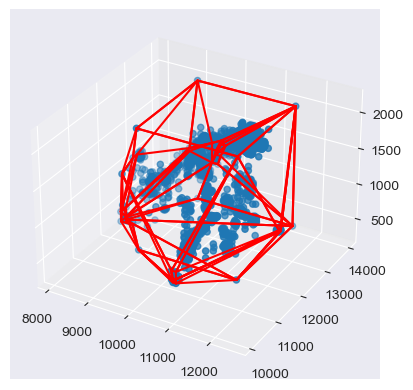

In [19]:
# Create points for convex hull from bounding boxes
def create_convex_hull(df, group_id):
    # Get all points from bounding boxes for this group
    group_boxes = df[df['agglo_id'] == group_id]

    # Create points array from start coordinates and sizes
    points = []
    for _, box in group_boxes.iterrows():
        # Add all corners of the bounding box
        x, y, z = box['start_x'], box['start_y'], box['start_z']
        sx, sy, sz = box['size_x'], box['size_y'], box['size_z']

        # Add all 8 corners of the box
        points.extend([
            [x, y, z],
            [x+sx, y, z],
            [x, y+sy, z],
            [x, y, z+sz],
            [x+sx, y+sy, z],
            [x+sx, y, z+sz],
            [x, y+sy, z+sz],
            [x+sx, y+sy, z+sz]
        ])

    points = np.array(points)
    hull = ConvexHull(points)
    return points, hull

# Create convex hulls for each agglomeration ID
hulls = {}
for agglo_id in df['agglo_id'].unique():
    points, hull = create_convex_hull(df, agglo_id)
    hulls[agglo_id] = (points, hull)

# Visualize one convex hull (example for first agglo_id)
def plot_hull(points, hull):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    ax.scatter(points[:,0], points[:,1], points[:,2], 'ko')

    # Plot hull
    for simplex in hull.simplices:
        ax.plot3D(points[simplex, 0], points[simplex, 1], points[simplex, 2], 'r-')

    plt.show()

# Plot first hull as example
first_agglo_id = list(hulls.keys())[0]

plot_hull(*hulls[first_agglo_id])


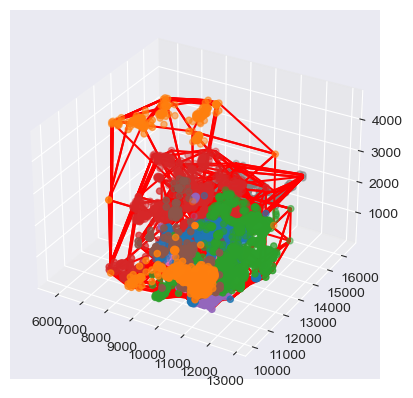

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for agglo_id, (points, hull) in hulls.items():
    # Plot points
    ax.scatter(points[:,0], points[:,1], points[:,2], 'ko')

    # Plot hull
    for simplex in hull.simplices:
        ax.plot3D(points[simplex, 0], points[simplex, 1], points[simplex, 2], 'r-')

plt.show()


In [22]:
# convert to mesh

import pymeshlab

In [23]:
agglo_1 = 72815935
agglo_2 = 23602233
agglo_3 = 67016897

In [26]:
hull1_points, hull1_faces = hulls[agglo_1]
hull2_points, hull2_faces = hulls[agglo_2]


In [45]:
"""Compute intersection between two convex hulls"""
# Create MeshSet for both hulls
ms = pymeshlab.MeshSet()

# Add first hul    """Compute intersection between two convex hulls"""
# Create MeshSet for both hulls
ms = pymeshlab.MeshSet()

# Add first hull
ms.add_mesh(pymeshlab.Mesh(vertex_matrix=hull1_points))
#orient_mesh_properly(ms)

# Add second hull
ms.add_mesh(pymeshlab.Mesh(vertex_matrix=hull2_points))
#orient_mesh_properly(ms)

# Compute boolean intersection
ms.generate_boolean_intersection(first_mesh=0, second_mesh=1)

# Get resulting intersection mesh
intersection_mesh = ms.current_mesh()


PyMeshLabException: Failed to apply filter: generate_boolean_intersection
Details: Error while creating mesh: Vertex matrix is empty.

In [44]:
h, l = hull1_faces

TypeError: cannot unpack non-iterable ConvexHull object

In [47]:
import numpy as np
from scipy.spatial import ConvexHull

def check_hull_overlap(hull1_points, hull2_points):
    """
    Check if two convex hulls overlap by checking if any point from one hull
    is inside the other hull.

    Returns:
        bool: True if hulls overlap, False otherwise
    """
    def point_in_hull(point, hull_points):
        """Check if point is inside convex hull"""
        hull = ConvexHull(hull_points)
        new_points = np.vstack((hull_points, point))
        new_hull = ConvexHull(new_points)
        return len(hull.vertices) == len(new_hull.vertices)

    # Check if any point from hull1 is inside hull2
    for point in hull1_points:
        if point_in_hull(point, hull2_points):
            return True

    # Check if any point from hull2 is inside hull1
    for point in hull2_points:
        if point_in_hull(point, hull1_points):
            return True

    return False

# Example usage:
points1, hull1 = hulls[agglo_1]
points2, hull2 = hulls[agglo_3]

if check_hull_overlap(points1, points2):
    print("Convex hulls overlap!")
else:
    print("Convex hulls do not overlap")

Convex hulls do not overlap


In [48]:
def analyze_hull_intersections(hulls_dict):
    """
    Analyze all pairwise intersections between convex hulls

    Args:
        hulls_dict: Dictionary of (points, hull) tuples keyed by agglo_id
    """
    intersections = []

    # Get all pairs of hulls
    agglo_ids = list(hulls_dict.keys())
    for i, id1 in enumerate(agglo_ids):
        for id2 in agglo_ids[i+1:]:
            points1, _ = hulls_dict[id1]
            points2, _ = hulls_dict[id2]

            if check_hull_overlap(points1, points2):
                intersections.append((id1, id2))

    return intersections

# Analyze all intersections
intersecting_pairs = analyze_hull_intersections(hulls)

# Print results
if intersecting_pairs:
    print("Found overlapping convex hulls:")
    for id1, id2 in intersecting_pairs:
        print(f"Agglomeration {id1} overlaps with {id2}")
else:
    print("No overlapping convex hulls found")

Found overlapping convex hulls:
Agglomeration 23602233 overlaps with 66090332
Agglomeration 23602233 overlaps with 66120761
Agglomeration 23602233 overlaps with 66892606
Agglomeration 23602233 overlaps with 67016249
Agglomeration 23602233 overlaps with 67016897
Agglomeration 23602233 overlaps with 67017133
Agglomeration 23602233 overlaps with 72815935
Agglomeration 66090332 overlaps with 66120761
Agglomeration 66090332 overlaps with 66892606
Agglomeration 66090332 overlaps with 67016249
Agglomeration 66090332 overlaps with 67016897
Agglomeration 66090332 overlaps with 67017133
Agglomeration 66090332 overlaps with 72815935
Agglomeration 66120761 overlaps with 66892606
Agglomeration 66120761 overlaps with 67016249
Agglomeration 66120761 overlaps with 67016897
Agglomeration 66120761 overlaps with 67017133
Agglomeration 66120761 overlaps with 72815935
Agglomeration 66892606 overlaps with 67016249
Agglomeration 66892606 overlaps with 67016897
Agglomeration 66892606 overlaps with 67017133
Ag

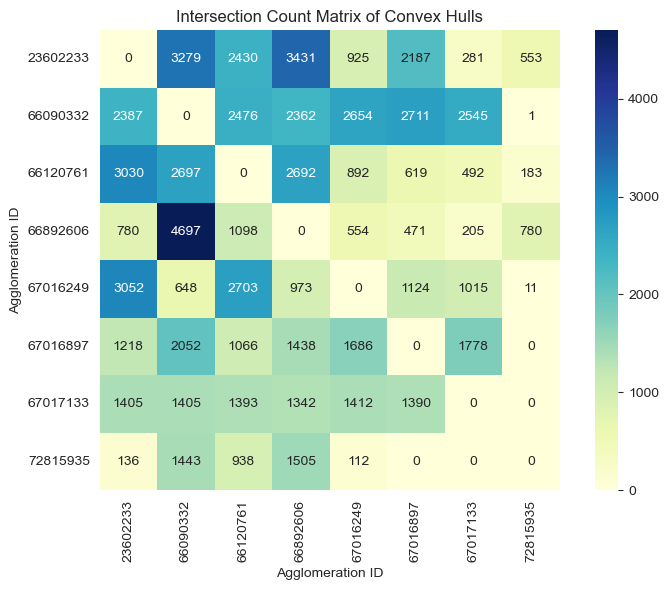

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create the intersection matrix
def create_intersection_matrix(hulls):
    agglo_ids = list(hulls.keys())
    num_hulls = len(agglo_ids)
    intersection_counts = np.zeros((num_hulls, num_hulls), dtype=int)

    def point_in_hull(point, hull_points):
        """Check if point is inside convex hull"""
        hull = ConvexHull(hull_points)
        new_points = np.vstack((hull_points, point))
        new_hull = ConvexHull(new_points)
        return len(hull.vertices) == len(new_hull.vertices)

    # Calculate intersections
    for i in range(num_hulls):
        for j in range(num_hulls):
            if i != j:
                points1, _ = hulls[agglo_ids[i]]
                points2, _ = hulls[agglo_ids[j]]
                # Count points from hull1 that are inside hull2
                count = sum(1 for point in points1 if point_in_hull(point, points2))
                intersection_counts[i, j] = count

    return intersection_counts, agglo_ids

# Calculate intersection matrix
intersection_counts, agglo_ids = create_intersection_matrix(hulls)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(intersection_counts,
            annot=True,            # Show numbers in cells
            fmt="d",               # Format numbers as integers
            cmap="YlGnBu",        # Color scheme from light yellow to green to blue
            xticklabels=agglo_ids,
            yticklabels=agglo_ids,
            square=True)          # Make cells square

plt.title('Intersection Count Matrix of Convex Hulls')
plt.xlabel('Agglomeration ID')
plt.ylabel('Agglomeration ID')
plt.tight_layout()
plt.show()

In [36]:
def check_hull_overlap(hull1_points, hull2_points):
    """
    Optimized overlap check with early exit
    """
    # First check bounding boxes for quick rejection
    min1 = np.min(hull1_points, axis=0)
    max1 = np.max(hull1_points, axis=0)
    min2 = np.min(hull2_points, axis=0)
    max2 = np.max(hull2_points, axis=0)

    # Quick rejection test
    if (max1[0] < min2[0] or min1[0] > max2[0] or
            max1[1] < min2[1] or min1[1] > max2[1] or
            max1[2] < min2[2] or min1[2] > max2[2]):
        return False, 0

    # Only check a subset of points for faster testing
    step = max(1, len(hull1_points) // 10)  # Check ~10% of points
    count = 0

    for point in hull1_points[::step]:
        if point_in_hull(point, hull2_points):
            count += 1
            if count > 0:  # Early exit once we find any intersection
                return True, count

    return False, count

PyMeshLabException: Failed to apply filter: laplacian_smooth
Filter does not exists. Take a look at MeshSet.print_filter_list function.

In [53]:
ms = pymeshlab.MeshSet()
# Add points as mesh
ms.add_mesh(pymeshlab.Mesh(vertex_matrix=points))
# First, compute normals for the point cloud
ms.compute_normal_for_point_clouds(k=20,  # increase number of neighbors
smoothiter=2)

# Apply Poisson reconstruction with parameters for watertight mesh
ms.generate_surface_reconstruction_screened_poisson(
    depth=10,  # increase depth for more detail
    pointweight=4,  # increase point weight for better surface adherence
    fulldepth=5,
    scale=1.1,
    samplespernode=1.5,
    confidence=True,
    preclean=True
)

# Clean up the resulting mesh
ms.meshing_remove_duplicate_vertices()
ms.meshing_remove_duplicate_faces()
ms.meshing_remove_unreferenced_vertices()

# Get the resulting mesh
mesh = ms.current_mesh()
vertices = mesh.vertex_matrix()
faces = mesh.face_matrix()

viewer.add_surface((vertices,faces))

PyMeshLabException: Failed to apply filter: generate_surface_reconstruction_screened_poisson
Details: Filter requires correct per vertex normals.<br>E.g. it is necessary that your <b>ALL</b> the input vertices have a proper, not-null normal.<br> Try enabling the <i>pre-clean<i> option and retry.<br><br>To permanently remove this problem:<br>If you encounter this error on a triangulated mesh try to use the <i>Remove Unreferenced Vertices</i> filterIf you encounter this error on a pointcloud try to use the <i>Conditional Vertex Selection</i> filterwith function '(nx==0.0) && (ny==0.0) && (nz==0.0)', and then <i>delete selected vertices</i>.<br>

In [ ]:
import pymeshlab
import numpy as np

# Create a MeshSet object
ms = pymeshlab.MeshSet()

# Add points as mesh
ms.add_mesh(pymeshlab.Mesh(vertex_matrix=points))

# 1. Initial cleaning
ms.meshing_remove_duplicate_vertices()
ms.meshing_remove_unreferenced_vertices()

# 2. Compute normals with specific orientation
ms.compute_normal_for_point_clouds(
    k=50,  # increased neighbors for better normal estimation
    smoothiter=5,
    viewpos=[0, 0, 100],  # adjust based on your point cloud orientation
    flipflag=False
)

# 3. Explicitly remove points with invalid normals
ms.compute_selection_by_condition_per_vertex(
    condselect="(nx*nx + ny*ny + nz*nz) < 0.1"
)
ms.meshing_remove_selected_vertices()

# 4. Try Alpha Shape reconstruction instead of Poisson
ms.create_surface_reconstruction_alpha_wrap(
    threshold=pymeshlab.Percentage(5.0),
    allowsubvolumes=True
)

# 5. Post-processing
ms.meshing_repair_non_manifold_edges()
ms.meshing_close_holes(
    maxholesize=50,
    selfintersection=True
)

# 6. Optional smoothing
ms.apply_filter('apply_coord_taubin_smoothing',
                lambda_=0.3,
                mu=-0.32,
                stepsmoothnum=5)

# Get the resulting mesh
mesh = ms.current_mesh()
vertices = mesh.vertex_matrix()
faces = mesh.face_matrix()

# Visualize in napari
import napari
viewer = napari.Viewer()

# Show original points
viewer.add_points(
    points,
    size=5,
    name='Original Points',
    face_color='white'
)

# Show reconstructed surface
viewer.add_surface(
    (vertices, faces),
    name='Reconstructed Surface',
    colormap='bop orange',
    opacity=0.7
)

In [24]:
import pymeshlab
import numpy as np

def is_point_inside_hull(point, vertices, faces):
    """Check if point is inside hull using signed distance"""
    def unit_normal(face):
        v1 = vertices[face[1]] - vertices[face[0]]
        v2 = vertices[face[2]] - vertices[face[0]]
        normal = np.cross(v1, v2)
        return normal / np.linalg.norm(normal)

    def signed_distance(point, face_vertex, normal):
        return np.dot(normal, (point - face_vertex))

    # Check if point is inside all faces
    for face in faces:
        normal = unit_normal(face)
        dist = signed_distance(point, vertices[face[0]], normal)
        if dist > 1e-10:  # Small epsilon for numerical stability
            return False
    return True

def orient_mesh_properly(ms):
    """Orient mesh faces properly"""
    # First repair any non-manifold edges
    ms.apply_filter('meshing_repair_non_manifold_edges')
    ms.apply_filter('meshing_re_orient_faces_coherently')

    # Get current mesh data
    mesh = ms.current_mesh()
    vertices = mesh.vertex_matrix()
    faces = mesh.face_matrix()

    # Check orientation using first face
    face = faces[0]
    v1 = vertices[face[1]] - vertices[face[0]]
    v2 = vertices[face[2]] - vertices[face[0]]
    normal = np.cross(v1, v2)
    normal = normal / np.linalg.norm(normal)

    # Test point slightly offset from face center
    face_center = vertices[face].mean(axis=0)
    test_point = face_center + normal * 1e-4

    # If test point is outside, invert orientation
    if not is_point_inside_hull(test_point, vertices, faces):
        ms.apply_filter('meshing_invert_face_orientation')

In [25]:
def compute_hull_intersection(hull1_points, hull1_faces, hull2_points, hull2_faces):
    """Compute intersection between two convex hulls"""
    # Create MeshSet for both hulls
    ms = pymeshlab.MeshSet()

    # Add first hull
    ms.add_mesh(pymeshlab.Mesh(vertex_matrix=hull1_points, face_matrix=hull1_faces))
    orient_mesh_properly(ms)

    # Add second hull
    ms.add_mesh(pymeshlab.Mesh(vertex_matrix=hull2_points, face_matrix=hull2_faces))
    orient_mesh_properly(ms)

    # Compute boolean intersection
    ms.generate_boolean_intersection(first=0, second=1)

    # Get resulting intersection mesh
    intersection_mesh = ms.current_mesh()
    return intersection_mesh.vertex_matrix(), intersection_mesh.face_matrix()

In [ ]:
import pyvista as pv

# Load or create meshes
mesh1 = pv.Sphere()
mesh2 = pv.Sphere()

# Compute intersection
intersection, mesh1_split, mesh2_split = mesh1.intersection(mesh2,
                                                            split_first=True,
                                                            split_second=True)

In [26]:

# Use the function with your hulls
for agglo_id1, (points1, hull1) in hulls.items():
    for agglo_id2, (points2, hull2) in hulls.items():
        if agglo_id1 < agglo_id2:  # Avoid duplicate comparisons
            try:
                # Compute intersection
                int_vertices, int_faces = compute_hull_intersection(
                    points1, hull1.simplices,
                    points2, hull2.simplices
                )

                # Visualize in napari if intersection exists
                if len(int_vertices) > 0:
                    viewer.add_surface(
                        (int_vertices, int_faces),
                        name=f'intersection_{agglo_id1}_{agglo_id2}',
                        colormap='yellow',
                        opacity=0.7
                    )
            except Exception as e:
                print(f"Failed to compute intersection between {agglo_id1} and {agglo_id2}: {e}")

Failed to compute intersection between 23602233 and 66090332: Parameter first not found for filter generate_boolean_intersection. Please check the documentation.
Failed to compute intersection between 23602233 and 66120761: Parameter first not found for filter generate_boolean_intersection. Please check the documentation.
Failed to compute intersection between 23602233 and 66892606: Parameter first not found for filter generate_boolean_intersection. Please check the documentation.
Failed to compute intersection between 23602233 and 67016249: Parameter first not found for filter generate_boolean_intersection. Please check the documentation.
Failed to compute intersection between 23602233 and 67016897: Parameter first not found for filter generate_boolean_intersection. Please check the documentation.
Failed to compute intersection between 23602233 and 67017133: Parameter first not found for filter generate_boolean_intersection. Please check the documentation.
Failed to compute intersecti

<Surface layer 'Surface [6]' at 0x1ce94341c70>

In [41]:
viewer = napari.Viewer()
viewer.add_points(points)
viewer.add_surface((vertices,faces))

<Surface layer 'Surface' at 0x1ce9334f850>

In [41]:
points, hull = hulls[first_agglo_id]
viewer = napari.Viewer()
viewer.add_points(points)

<Points layer 'points' at 0x2b39f9315e0>

In [116]:
import napari
import numpy as np
from skimage import measure
from scipy.ndimage import zoom

# Get points from hull
points, hull = hulls[first_agglo_id]

# Find the bounds of the volume
max_coords = points.max(axis=0)
min_coords = points.min(axis=0)

# Create a grid with some padding but at a lower resolution
padding = 10
downsample_factor = 8  # Increase this value if still running into memory issues
grid_shape = ((max_coords - min_coords + 2*padding)/downsample_factor).astype(int)

# Initialize empty volume at lower resolution
volume = np.zeros(grid_shape, dtype=bool)

# Convert points to volume coordinates and scale down
points_shifted = ((points - min_coords + padding)/downsample_factor).astype(int)

# Mark points in volume
for point in points_shifted:
    try:
        volume[point[0], point[1], point[2]] = True
    except IndexError:
        continue  # Skip points that fall outside the volume

# Apply gaussian smoothing to create a more continuous surface
from scipy.ndimage import gaussian_filter
volume_smooth = gaussian_filter(volume.astype(float), sigma=1)

# Apply marching cubes
verts, faces, normals, values = measure.marching_cubes(volume_smooth, 0.2)

# Scale vertices back up and shift to original coordinate system
verts = verts * downsample_factor + min_coords - padding

# Create viewer and add visualizations
viewer = napari.Viewer()

# Add original points
viewer.add_points(points, size=5, name='Original Points', face_color='blue')

# Add marching cubes surface
viewer.add_surface(
    (verts, faces),
    name='Marching Cubes Surface',
    colormap='red',
    opacity=0.5,
    shading='smooth'
)

# Center view
viewer.camera.center = points.mean(axis=0)

In [119]:
import napari
from napari_pymeshlab import (
    convex_hull,
    laplacian_smooth,
    taubin_smooth,
    simplification_clustering_decimation,
)

from skimage.measure import marching_cubes
colormaps = ['blue', 'green', 'red', 'cyan', 'magenta','bop purple', "bop orange",'blue', 'green', 'red', 'cyan']

# Create viewer
viewer = napari.Viewer()
idx = 0
for agglo_id, (points, hull) in hulls.items():

    # Add the bounding box corner points
    points_layer = viewer.add_points(
        points,
        size=5,
        name=agglo_id,
        face_color=colormaps[idx]
    )

    # Convert points to surface format that pymeshlab can use
    vertices = points
    faces = hull.simplices

    # Create initial surface using vertices and faces
    surface = (vertices, faces)
    hull_surface = convex_hull(surface)


    # Apply smoothing to make the surface more natural
    smoothed_surface = laplacian_smooth(surface,step_smooth_num=2)

    viewer.add_surface(
        smoothed_surface,
        name=f'convex hull {agglo_id}',
        colormap=colormaps[idx],
        opacity=0.7
    )

    idx+=1

C:\Users\montruth\miniconda3\envs\apr\lib\site-packages\napari\layers\utils\color_transformations.py:42: UserWarning: The provided colors parameter contained illegal values, resetting all colors values to white.
  warnings.warn(
C:\Users\montruth\miniconda3\envs\apr\lib\site-packages\napari\layers\utils\color_transformations.py:42: UserWarning: The provided colors parameter contained illegal values, resetting all colors values to white.
  warnings.warn(


In [122]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:

import numpy as np
import pandas as pd

import napari

from brainmaps_api_fcn.equivalence_requests import EquivalenceRequests
from brainmaps_api_fcn.subvolume_requests import SubvolumeRequest

# Get the agglomerated ID that contains EM centroid
def get_agglo_group_from_point(sa, volume_id, stack_change, centroid_xyz):
    sr = SubvolumeRequest(sa, volume_id)
    vol = sr.get_subvolume(centroid_xyz, size= [1,1,1], change_stack_id = stack_change)
    agglo_id  = int(np.unique(vol[vol>0]))
    print(f"ID found: {agglo_id}")

    er = EquivalenceRequests(sa, volume_id, stack_change)
    group = er.get_groups(agglo_id)
    return group


In [ ]:

sa = r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\Reconstruction\fmi-friedrich-4dd3f21e665d.json"
volume_id = r"280984173682:montano_rm2_ngff:raw_230701_seg_240316fb"
stack_change = "240705d_rsg9_spl"

In [ ]:
#TODO: Read list/csv
centroids_xyz = np.array([[10656, 10878, 1463], [10384, 10242, 1348], [10837, 10333, 1251], [11177, 10700, 724], [10566, 14567, 1828], [10817, 10322, 1268],
                          [11615, 13345, 1800],[11189, 12162, 2454],[11483, 12210, 2088]])



# Create dictionary of groups
groups_dict = {}
for point in centroids_xyz:
    group = get_agglo_group_from_point(sa, volume_id, stack_change, point)
    groups_dict[tuple(point)] = group

In [ ]:
print(groups_dict)

In [ ]:
# Create list to store data
data_rows = []

# Iterate through the dictionary
for point, agglo_groups in groups_dict.items():
    for agglo_id, segments in agglo_groups.items():
        # Add a row for each segment in the group
        for segment_id in segments:
            data_rows.append({
                'volume_id': volume_id,
                'stack_change': stack_change,
                'point_x': point[0],
                'point_y': point[1],
                'point_z': point[2],
                'agglo_id': agglo_id,
                'segment_id': segment_id
            })

# Create DataFrame
df = pd.DataFrame(data_rows)

# Sort the DataFrame
df = df.sort_values(['agglo_id', 'segment_id'])

# Display the first few rows
df.head()

In [ ]:
df.to_csv('segment_mapping.csv', index=False)

In [ ]:
segment_list = df.segment_id.to_list()

In [ ]:
# Alternative: save as comma-separated values
with open('segment_list.txt', 'w') as f:
    f.write(','.join(map(str, segment_list)))

In [ ]:
# QUERY command: SELECT id, bbox FROM `fmi-friedrich.ruth_ob.raw_230701_seg_240316fb_objinfo` WHERE id IN(segment1, segment2,...)

# saved as csv

In [ ]:
segment_info = pd.read_csv("bquxjob_338f3367_19330a661a5.csv")
segment_info.head()

In [ ]:
coords_df = segment_info.rename(columns={
    'x': 'start_x',
    'y': 'start_y',
    'z': 'start_z',
    'x_1': 'size_x',
    'y_1': 'size_y',
    'z_1': 'size_z'
})

In [ ]:
coords_df.head()

In [ ]:
# Merge with your previous DataFrame based on segment ID
df = df.merge(coords_df, left_on='segment_id', right_on='id', how='left')

df.head()

In [ ]:

# Clean up by dropping the redundant 'id' column if needed
df = df.drop('id', axis=1)
df.head()

In [ ]:

# Sort the DataFrame
df = df.sort_values(['agglo_id'])

df.head()

In [ ]:
df.to_csv('segment_mapping_bbox.csv', index=False)

In [ ]:
# Create convex hull from bounding box
import numpy as np
from scipy.spatial import ConvexHull
import pandas as pd
import matplotlib.pyplot as plt

# Create points for convex hull from bounding boxes
def create_convex_hull(df, group_id):
    # Get all points from bounding boxes for this group
    group_boxes = df[df['agglo_id'] == group_id]

    # Create points array from start coordinates and sizes
    points = []
    for _, box in group_boxes.iterrows():
        # Add all corners of the bounding box
        x, y, z = box['start_x'], box['start_y'], box['start_z']
        sx, sy, sz = box['size_x'], box['size_y'], box['size_z']

        # Add all 8 corners of the box
        points.extend([
            [x, y, z],
            [x+sx, y, z],
            [x, y+sy, z],
            [x, y, z+sz],
            [x+sx, y+sy, z],
            [x+sx, y, z+sz],
            [x, y+sy, z+sz],
            [x+sx, y+sy, z+sz]
        ])

    points = np.array(points)
    hull = ConvexHull(points)
    return points, hull

# Create convex hulls for each agglomeration ID
hulls = {}
for agglo_id in df['agglo_id'].unique():
    points, hull = create_convex_hull(df, agglo_id)
    hulls[agglo_id] = (points, hull)

# Visualize one convex hull (example for first agglo_id)
def plot_hull(points, hull):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    ax.scatter(points[:,0], points[:,1], points[:,2], 'ko')

    # Plot hull
    for simplex in hull.simplices:
        ax.plot3D(points[simplex, 0], points[simplex, 1], points[simplex, 2], 'r-')

    plt.show()

# Plot first hull as example
first_agglo_id = list(hulls.keys())[0]
plot_hull(*hulls[first_agglo_id])

In [ ]:
points, hull = hulls[first_agglo_id]
viewer = napari.Viewer()
viewer.add_points(points)

In [1]:
import napari
from napari_pymeshlab import (
    convex_hull,
    laplacian_smooth,
    taubin_smooth,
    simplification_clustering_decimation,
)

from skimage.measure import marching_cubes
colormaps = ['blue', 'green', 'red', 'cyan', 'magenta','bop purple', "bop orange",'blue', 'green', 'red', 'cyan']

# Create viewer
viewer = napari.Viewer()
idx = 0
for agglo_id, (points, hull) in hulls.items():

    # Add the bounding box corner points
    points_layer = viewer.add_points(
        points,
        size=5,
        name=agglo_id,
        face_color=colormaps[idx]
    )

    # Convert points to surface format that pymeshlab can use
    vertices = points
    faces = hull.simplices

    # Create initial surface using vertices and faces
    surface = (vertices, faces)
    hull_surface = convex_hull(surface)


    # Apply smoothing to make the surface more natural
    smoothed_surface = laplacian_smooth(surface,step_smooth_num=2)

    viewer.add_surface(
        smoothed_surface,
        name=f'convex hull {agglo_id}',
        colormap=colormaps[idx],
        opacity=0.7
    )

    idx+=1

NameError: name 'hulls' is not defined

In [ ]:
import open3d as o3d
points, hull = hulls[first_agglo_id]
# Create point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
# First, estimate normals
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30)
)

# Orient normals consistently
pcd.orient_normals_consistent_tangent_plane(100)

# Calculate appropriate radii based on point cloud density
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = avg_dist * 10

# Generate mesh using Ball-Pivoting Algorithm
radii = [radius, radius * 2, radius * 4]
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, o3d.utility.DoubleVector(radii)
)

# Visualize in napari
vertices = np.asarray(mesh.vertices)
faces = np.asarray(mesh.triangles)
values = np.ones(len(vertices))
viewer = napari.Viewer()
viewer.add_surface((vertices, faces))
viewer.add_points(points)


In [ ]:
agglo_1 = 72815935
agglo_2 = 23602233
agglo_3 = 67016897

In [ ]:
# Calculate overlap
import trimesh
vertices, hull = hulls[agglo_1]
# Use hull.simplices instead of hull directly
faces = hull.simplices
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

In [ ]:
viewer.add_surface((vertices, faces))

In [ ]:
import trimesh
import numpy as np
import pandas as pd

def compute_hull_overlaps(hulls):
    # Get unique segment IDs
    segment_ids = list(hulls.keys())
    n_segments = len(segment_ids)

    # Create empty overlap matrix
    overlap_matrix = np.zeros((n_segments, n_segments))

    # Convert hull data into trimesh objects
    meshes = {}
    for segment_id, (vertices, faces) in hulls.items():
        # Create mesh and ensure it's watertight
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        # Fix potential mesh issues
        mesh.fix_normals()
        mesh.fill_holes()
        mesh.remove_degenerate_faces()
        mesh.remove_duplicate_faces()
        meshes[segment_id] = mesh

    # Calculate overlaps
    for i, id1 in enumerate(segment_ids):
        for j, id2 in enumerate(segment_ids):
            if i < j:  # Only compute upper triangle (symmetric matrix)
                mesh1 = meshes[id1]
                mesh2 = meshes[id2]
                try:
                    # Check if meshes are valid
                    if mesh1.is_watertight and mesh2.is_watertight:
                        # Compute intersection
                        intersection = trimesh.boolean.intersection([mesh1, mesh2])
                        if intersection is not None:
                            overlap_volume = intersection.volume
                            # Store volume in both positions (symmetric matrix)
                            overlap_matrix[i, j] = overlap_volume
                            overlap_matrix[j, i] = overlap_volume
                except Exception as e:
                    print(f"Error computing overlap between segments {id1} and {id2}: {e}")

    # Create DataFrame for better visualization
    overlap_df = pd.DataFrame(
        overlap_matrix,
        index=segment_ids,
        columns=segment_ids
    )

    # Compute percentage overlap
    volumes = {sid: meshes[sid].volume for sid in segment_ids}
    percent_matrix = np.zeros_like(overlap_matrix)

    for i, id1 in enumerate(segment_ids):
        for j, id2 in enumerate(segment_ids):
            if i != j and overlap_matrix[i, j] > 0:
                min_volume = min(volumes[id1], volumes[id2])
                percent_matrix[i, j] = (overlap_matrix[i, j] / min_volume) * 100

    percent_df = pd.DataFrame(
        percent_matrix,
        index=segment_ids,
        columns=segment_ids
    )

    return overlap_df, percent_df, volumes

# Compute overlaps
overlap_df, percent_df, volumes = compute_hull_overlaps(hulls)

print("\nVolumes of individual segments (cubic units):")
for segment_id, volume in volumes.items():
    print(f"Segment {segment_id}: {volume:.2f}")

print("\nOverlap Volumes (cubic units):")
print(overlap_df)

print("\nOverlap Percentages (%):")
print(percent_df)

In [ ]:
overlaps

In [ ]:
@pip install trimesh

In [ ]:

# Add surface using triangular faces
vertices = points
faces = hull.simplices

viewer.add_surface(
    (vertices, faces),
    name='Convex Hull',
    colormap='red',
    opacity=0.5
)



In [ ]:
import napari
import numpy as np
from scipy.spatial import ConvexHull
from napari_pymeshlab import (
    convex_hull,
    laplacian_smooth,
    taubin_smooth,
    simplification_clustering_decimation,
    colorize_curvature_apss,
    make_shell
)

# Create viewer
viewer = napari.Viewer()

# Get points for first_agglo_id
points = df[df['agglo_id'] == first_agglo_id][['start_x', 'start_y', 'start_z']].values

# Add original points
points_layer = viewer.add_points(points, size=10, name='Original Points', face_color='blue')

# Create initial surface using convex hull
hull_surface = convex_hull(points)

# Apply smoothing filters
smoothed_surface = laplacian_smooth(hull_surface, step_smooth_num=3)

# Optional: apply Taubin smoothing instead
# smoothed_surface = taubin_smooth(hull_surface)

# Optional: simplify the mesh
# simplified_surface = simplification_clustering_decimation(smoothed_surface)

# Add curvature coloring
colored_surface = colorize_curvature_apss(smoothed_surface)

# Optional: create a shell with thickness
# final_surface = make_shell(colored_surface, thickness=2.0)

# Center view on points
viewer.camera.center = points.mean(axis=0)

In [ ]:
from skimage.measure import marching_cubes
from napari_pymeshlab import convex_hull, \
    laplacian_smooth, \
    taubin_smooth, \
    simplification_clustering_decimation, \
    colorize_curvature_apss, \
    make_shell

In [ ]:
import numpy as np
import napari

def create_binary_mask_from_segments(df, groups_dict, point_key, volume_shape=None):
    """
    Create a 3D binary mask from segments in an agglomeration

    Parameters:
    df: DataFrame with segment coordinates and sizes
    groups_dict: Dictionary mapping points to agglomeration groups
    point_key: Tuple of coordinates identifying the agglomeration
    volume_shape: Optional tuple defining the volume size (x,y,z)
    """
    # Get segments for this agglomeration
    agglo_groups = groups_dict[point_key]

    # If volume_shape not provided, calculate from data
    if volume_shape is None:
        max_x = df['x'].max() + df['x_1'].max()
        max_y = df['y'].max() + df['y_1'].max()
        max_z = df['z'].max() + df['z_1'].max()
        volume_shape = (max_x + 1, max_y + 1, max_z + 1)

    # Create empty binary mask
    mask = np.zeros(volume_shape, dtype=bool)

    # Fill mask with segments
    for agglo_id, segments in agglo_groups.items():
        print(f"Processing agglomeration ID: {agglo_id}")

        for segment_id in segments:
            segment_data = df[df['id'] == segment_id]
            if len(segment_data) == 0:
                continue

            # Get coordinates and size
            x = int(segment_data['x'].iloc[0])
            y = int(segment_data['y'].iloc[0])
            z = int(segment_data['z'].iloc[0])

            size_x = int(segment_data['x_1'].iloc[0])
            size_y = int(segment_data['y_1'].iloc[0])
            size_z = int(segment_data['z_1'].iloc[0])

            # Set mask to True for this segment
            mask[x:x+size_x, y:y+size_y, z:z+size_z] = True

    return mask

# Example usage:
point_key = tuple(centroids_xyz[0])  # First point
mask = create_binary_mask_from_segments(df, groups_dict, point_key)

# Visualize in napari
viewer = napari.Viewer()
viewer.add_image(mask, name='Binary Mask', colormap='red', opacity=0.5)
napari.run()

In [ ]:
first_agglo_id = list(hulls.keys())[0]
print(first_agglo_id)
group_convex_hull = create_convex_hull(df, first_agglo_id)

In [ ]:
print(group_convex_hull)

In [ ]:
viewer = napari.Viewer()

In [ ]:
import napari
import numpy as np
from napari_pymeshlab import (
    convex_hull,
    laplacian_smooth,
    taubin_smooth,
    simplification_clustering_decimation,
    colorize_curvature_apss,
    make_shell
)

# Create viewer
viewer = napari.Viewer()

# Function to create box vertices and faces
def create_box_mesh(start_coords, size):
    vertices = np.array([
        start_coords,
        start_coords + [size[0], 0, 0],
        start_coords + [0, size[1], 0],
        start_coords + [0, 0, size[2]],
        start_coords + [size[0], size[1], 0],
        start_coords + [size[0], 0, size[2]],
        start_coords + [0, size[1], size[2]],
        start_coords + size
    ])

    faces = np.array([
        [0,1,2], [1,4,2],  # front
        [0,2,3], [2,6,3],  # left
        [1,5,4], [4,5,7],  # right
        [2,4,6], [4,7,6],  # top
        [0,3,1], [1,3,5],  # bottom
        [3,6,7], [3,7,5]   # back
    ])
    return vertices, faces

# Get first segment data
segment_id = 116984320  # example segment
start = np.array([11315, 11308, 1028])
size = np.array([40, 16, 15])

# Create initial mesh
vertices, faces = create_box_mesh(start, size)

# Add initial mesh to viewer
mesh_layer = viewer.add_surface((vertices, faces), name='Original')

# Apply mesh processing operations
# 1. Create convex hull
hull_verts, hull_faces = convex_hull((vertices, faces))
viewer.add_surface((hull_verts, hull_faces), name='Convex Hull', colormap='blue')

# 2. Apply smoothing
smooth_verts, smooth_faces = laplacian_smooth((hull_verts, hull_faces), iterations=5)
viewer.add_surface((smooth_verts, smooth_faces), name='Smoothed', colormap='green')

# 3. Create shell
shell_verts, shell_faces = make_shell((smooth_verts, smooth_faces), thickness=2.0)
viewer.add_surface((shell_verts, shell_faces), name='Shell', colormap='red')

# 4. Add curvature coloring
colored_verts = colorize_curvature_apss((shell_verts, shell_faces))
viewer.add_surface((colored_verts, shell_faces), name='Curvature', colormap='viridis')

# Optional: Simplify mesh if needed
simplified_verts, simplified_faces = simplification_clustering_decimation(
    (shell_verts, shell_faces),
    cell_size=5.0
)
viewer.add_surface((simplified_verts, simplified_faces), name='Simplified', colormap='magma')

napari.run()

In [ ]:
import napari
import numpy as np
from napari_pymeshlab import convex_hull

# Create viewer
viewer = napari.Viewer()

# Function to create box vertices and faces
def create_box_mesh(start_coords, size):
    vertices = np.array([
        start_coords,
        start_coords + [size[0], 0, 0],
        start_coords + [0, size[1], 0],
        start_coords + [0, 0, size[2]],
        start_coords + [size[0], size[1], 0],
        start_coords + [size[0], 0, size[2]],
        start_coords + [0, size[1], size[2]],
        start_coords + size
    ])

    faces = np.array([
        [0,1,2], [1,4,2],  # front
        [0,2,3], [2,6,3],  # left
        [1,5,4], [4,5,7],  # right
        [2,4,6], [4,7,6],  # top
        [0,3,1], [1,3,5],  # bottom
        [3,6,7], [3,7,5]   # back
    ])
    return vertices, faces

# Get first segment data
start = np.array([11315, 11308, 1028])
size = np.array([40, 16, 15])

# Create initial mesh
vertices, faces = create_box_mesh(start, size)

# Add initial mesh to viewer
mesh_layer = viewer.add_surface((vertices, faces), name='Original')

# Apply convex hull
# The function returns a tuple with the new mesh data
hull_data = convex_hull((vertices, faces))
# Extract vertices and faces from the returned data
hull_verts = hull_data[0]
hull_faces = hull_data[1]

# Add convex hull to viewer
viewer.add_surface((hull_verts, hull_faces), name='Convex Hull', colormap='blue')

napari.run()

In [ ]:
np.unique(df.agglo_id)

In [ ]:
df.segment_id[df.agglo_id==np.unique(df.agglo_id)[0]]

In [ ]:
agglo_id_test = np.unique(df.agglo_id)[0]
segments_list = df.segment_id[df.agglo_id==agglo_id_test].tolist()
print(segments_list)

In [ ]:
def get_segment_coords(df, segment_id):
    """
    Get start coordinates and size for a specific segment_id

    Parameters:
    df: DataFrame containing segment information
    segment_id: ID of the segment to look up

    Returns:
    tuple: (start_coords, size) or None if segment not found
    """
    # Filter DataFrame for the specific segment_id
    segment = df[df['segment_id'] == segment_id]

    if len(segment) == 0:
        print(f"Segment ID {segment_id} not found")
        return None

    # Get start coordinates and size
    start_coords = np.array([
        segment['start_x'].iloc[0],
        segment['start_y'].iloc[0],
        segment['start_z'].iloc[0]
    ])

    size = np.array([
        segment['size_x'].iloc[0],
        segment['size_y'].iloc[0],
        segment['size_z'].iloc[0]
    ])

    return start_coords, size

In [ ]:
coords = get_segment_coords(df, segment_list[0])

if coords:
    start_coords, size = coords
    print(f"Segment {segment_id}:")
    print(f"Start coordinates: {start_coords}")
    print(f"Size: {size}")

In [ ]:

for segment_id in segments_list[:100]:
    start_coords, size = get_segment_coords(df, segment_id)
    # Create initial mesh
    vertices, faces = create_box_mesh(start_coords, size)

    # Add initial mesh to viewer
    mesh_layer = viewer.add_surface((vertices, faces), name=f'{segment_id}')


In [ ]:
import numpy as np
from napari_pymeshlab import convex_hull

def create_agglomeration_hull(df, agglo_id):
    """
    Create a convex hull from all segments in an agglomeration

    Parameters:
    df: DataFrame with segment coordinates
    groups_dict: Dictionary mapping points to agglomeration groups
    point_key: Tuple of coordinates identifying the agglomeration
    """
    # Get all segments for this agglomeration
    agglo_groups = groups_dict[point_key]

    # Initialize list to store all vertices
    all_vertices = []

    # Process each segment in the agglomeration
    for agglo_id, segments in agglo_groups.items():
        print(f"Processing agglomeration ID: {agglo_id}")

        for segment_id in segments:
            start_coords, size = get_segment_coords(df, segment_id)
            # Create mesh
            vertices, faces = create_box_mesh(start_coords, size)


            # Add vertices to the collection
            all_vertices.extend(vertices)

    # Convert to numpy array
    all_vertices = np.array(all_vertices)

    # Create faces for the combined vertices
    faces = np.array([[i, i+1, i+2] for i in range(0, len(all_vertices)-2)])

    # Create convex hull from all vertices
    hull_data = convex_hull((all_vertices, faces))

    return hull_data

# Example usage:
viewer = napari.Viewer()

# Choose a point from your data
point_key = tuple(centroids_xyz[0])

# Create hull for the agglomeration
hull_data = create_agglomeration_hull(df, agglo_id_test)

# Add to viewer
viewer.add_surface(
    (hull_data[0], hull_data[1]),
    name='Agglomeration_Hull',
    colormap='viridis',
    opacity=0.5
)

napari.run()

In [ ]:
import napari
import numpy as np
from napari_pymeshlab import convex_hull, taubin_smooth

def create_agglomeration_hull(df, agglo_id):
    """Create a convex hull from all segments in an agglomeration and apply Taubin smoothing"""
    # Get all segments for this agglomeration
    agglo_groups = groups_dict[point_key]

    # Initialize list to store all vertices
    all_vertices = []

    # Process each segment in the agglomeration
    for agglo_id, segments in agglo_groups.items():
        print(f"Processing agglomeration ID: {agglo_id}")

        for segment_id in segments:
            start_coords, size = get_segment_coords(df, segment_id)
            # Create mesh
            vertices, faces = create_box_mesh(start_coords, size)
            # Add vertices to the collection
            all_vertices.extend(vertices)

    # Convert to numpy array
    all_vertices = np.array(all_vertices)

    # Create faces for the combined vertices
    faces = np.array([[i, i+1, i+2] for i in range(0, len(all_vertices)-2)])

    # Create convex hull
    hull_data = convex_hull((all_vertices, faces))

    # Apply Taubin smoothing with correct parameter names
    smoothed_data = laplacian_smooth(
        hull_data, step_smooth_num=5)  # number of iterations


    return hull_data, smoothed_data

# Example usage:
viewer = napari.Viewer()

# Create hull and smooth it
hull_data, smoothed_data = create_agglomeration_hull(df, agglo_id_test)

# Hide all existing layers
for layer in viewer.layers:
    layer.visible = False

# Add original hull (hidden by default)
viewer.add_surface(
    hull_data,
    name='Original_Hull',
    colormap='viridis',
    opacity=0.5,
    visible=False
)

# Add smoothed surface
viewer.add_surface(
    smoothed_data,
    name='Smoothed_Hull',
    colormap='magma',
    opacity=0.5
)


napari.run()

In [ ]:
### start again
## Dummy test
import numpy as np
import pandas as pd

# Create dummy segments data
segments_data = {
    'id': range(1, 31),  # 30 segments total
    'x': np.random.randint(10000, 12000, 30),
    'y': np.random.randint(10000, 12000, 30),
    'z': np.random.randint(1000, 2500, 30),
    'x_1': np.random.randint(20, 70, 30),
    'y_1': np.random.randint(15, 50, 30),
    'z_1': np.random.randint(15, 35, 30)
}

df = pd.DataFrame(segments_data)

# Create 4 overlapping agglomerations
agglo_groups = {
    'agglo_1': list(range(1, 11)),           # segments 1-10
    'agglo_2': list(range(8, 18)),           # segments 8-17 (overlaps with agglo_1)
    'agglo_3': list(range(15, 25)),          # segments 15-24 (overlaps with agglo_2)
    'agglo_4': list(range(21, 31))           # segments 21-30 (overlaps with agglo_3)
}

# Add agglomeration IDs to DataFrame
df['agglo_id'] = None
for agglo_id, segments in agglo_groups.items():
    df.loc[df['id'].isin(segments), 'agglo_id'] = agglo_id

# Print overlap information
for agglo_id, segments in agglo_groups.items():
    print(f"\n{agglo_id} segments: {segments}")
    for other_agglo, other_segments in agglo_groups.items():
        if other_agglo != agglo_id:
            overlap = set(segments) & set(other_segments)
            if overlap:
                print(f"Overlaps with {other_agglo}: {list(overlap)}")

print("\nDataFrame head:")
df.head()



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique agglomeration IDs from your data
agglo_ids = [67017133, 66090332, 67016897, 67016249, 72815935, 67016897, 66120761, 66892606, 23602233]

# Create empty matrix
n = len(agglo_ids)
overlap_matrix = np.zeros((n, n), dtype=int)

# Fill the matrix
for i, agglo1 in enumerate(agglo_ids):
    for j, agglo2 in enumerate(agglo_ids):
        # Get segments for each agglomeration
        segments1 = set(groups_dict[tuple(centroids_xyz[i])][agglo1])
        segments2 = set(groups_dict[tuple(centroids_xyz[j])][agglo2])
        # Calculate overlap
        overlap = len(segments1.intersection(segments2))
        overlap_matrix[i,j] = overlap

# Create DataFrame
overlap_df = pd.DataFrame(
    overlap_matrix,
    index=[f'Agglo_{id}' for id in agglo_ids],
    columns=[f'Agglo_{id}' for id in agglo_ids]
)

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_df,
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='YlOrRd',  # Yellow to Red colormap
            square=True,    # Make cells square
            cbar_kws={'label': 'Number of shared segments'})

plt.title('Agglomeration Overlap Matrix')
plt.tight_layout()
plt.show()

# Also print the raw numbers
print("\nOverlap Matrix:")
print(overlap_df)

In [ ]:
import numpy as np
import pandas as pd

# Create dummy segments data with overlapping spatial regions but unique segment IDs
segments_data = {
    'id': range(1, 31),  # 30 unique segments
    'x': [
        # Agglomeration 1 (segments 1-10) - Central region
        10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900,
        # Agglomeration 2 (segments 11-20) - Overlaps with Agglomeration 1
        10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100,
        # Agglomeration 3 (segments 21-30) - Overlaps with Agglomeration 2
        10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300
    ],
    'y': [
        # Agglomeration 1
        10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900,
        # Agglomeration 2 (shifted)
        10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100,
        # Agglomeration 3 (shifted)
        10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300
    ],
    'z': [
        # All z coordinates
        1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900,
        1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900,
        1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900
    ],
    'x_1': [40] * 30,  # Size in x
    'y_1': [40] * 30,  # Size in y
    'z_1': [40] * 30   # Size in z
}

df = pd.DataFrame(segments_data)

# Create groups dictionary with spatially overlapping but unique segments
groups_dict = {
    (10500, 10500, 1500): {  # Central point
        'agglo_1': list(range(1, 11)),      # Segments 1-10
    },
    (10700, 10700, 1500): {  # Shifted point
        'agglo_2': list(range(11, 21)),     # Segments 11-20
    },
    (10900, 10900, 1500): {  # Further shifted point
        'agglo_3': list(range(21, 31)),     # Segments 21-30
    }
}

# Add agglomeration IDs to DataFrame
df['agglo_id'] = None
for point, agglos in groups_dict.items():
    for agglo_id, segments in agglos.items():
        df.loc[df['id'].isin(segments), 'agglo_id'] = agglo_id

print("\nDataFrame head:")
print(df.head())
print("\nSpatial overlap but unique segments:")
for point, agglos in groups_dict.items():
    print(f"\nPoint {point}:")
    for agglo_id, segments in agglos.items():
        print(f"{agglo_id}: {segments}")

In [ ]:
import napari
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from napari_pymeshlab import convex_hull, taubin_smooth

def create_overlap_matrix(groups_dict):
    """Create overlap matrix between agglomerations"""
    # Get unique agglomeration IDs
    agglo_ids = []
    for point, groups in groups_dict.items():
        for agglo_id in groups.keys():
            if agglo_id not in agglo_ids:
                agglo_ids.append(agglo_id)

    # Create empty matrix
    n = len(agglo_ids)
    overlap_matrix = np.zeros((n, n), dtype=int)

    # Fill matrix
    for i, agglo1 in enumerate(agglo_ids):
        for j, agglo2 in enumerate(agglo_ids):
            # Get segments for each agglomeration
            segments1 = set()
            segments2 = set()
            for point, groups in groups_dict.items():
                if agglo1 in groups:
                    segments1.update(groups[agglo1])
                if agglo2 in groups:
                    segments2.update(groups[agglo2])

            # Calculate overlap
            overlap = len(segments1.intersection(segments2))
            overlap_matrix[i,j] = overlap

    return overlap_matrix, agglo_ids

def visualize_agglomerations_and_matrix(df, groups_dict):
    """Visualize agglomerations in napari and overlap matrix in matplotlib"""
    # Create napari viewer
    viewer = napari.Viewer()

    # Create convex hulls for each agglomeration
    colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'cyan']
    color_idx = 0

    for point, groups in groups_dict.items():
        for agglo_id, segments in groups.items():
            # Get all vertices for segments in this agglomeration
            all_vertices = []
            for segment_id in segments:
                segment_data = df[df['id'] == segment_id]
                if len(segment_data) == 0:
                    continue

                # Get coordinates and size
                start = np.array([
                    segment_data['x'].iloc[0],
                    segment_data['y'].iloc[0],
                    segment_data['z'].iloc[0]
                ])
                size = np.array([
                    segment_data['x_1'].iloc[0],
                    segment_data['y_1'].iloc[0],
                    segment_data['z_1'].iloc[0]
                ])

                # Create box vertices
                vertices = np.array([
                    start,
                    start + [size[0], 0, 0],
                    start + [0, size[1], 0],
                    start + [0, 0, size[2]],
                    start + [size[0], size[1], 0],
                    start + [size[0], 0, size[2]],
                    start + [0, size[1], size[2]],
                    start + size
                ])
                all_vertices.extend(vertices)

            # Create convex hull
            vertices = np.array(all_vertices)
            faces = np.array([[i, i+1, i+2] for i in range(0, len(vertices)-2)])
            hull_data = convex_hull((vertices, faces))

            # Add to viewer
            viewer.add_surface(
                hull_data,
                name=f'Agglo_{agglo_id}',
                colormap=colors[color_idx % len(colors)],
                opacity=0.5
            )
            color_idx += 1

    # Create overlap matrix
    overlap_matrix, agglo_ids = create_overlap_matrix(groups_dict)

    # Plot matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlap_matrix,
                xticklabels=[f'Agglo_{id}' for id in agglo_ids],
                yticklabels=[f'Agglo_{id}' for id in agglo_ids],
                annot=True,
                fmt='d',
                cmap='YlOrRd')
    plt.title('Agglomeration Overlap Matrix')
    plt.tight_layout()
    plt.show()

    return viewer

# Use the function
viewer = visualize_agglomerations_and_matrix(df, groups_dict)
napari.run()

In [ ]:
df

In [89]:
agglo_1 = 72815935
agglo_2 = 23602233
agglo_3 = 67016897

In [91]:
# Calculate overlap
import trimesh
vertices, hull = hulls[agglo_1]
# Use hull.simplices instead of hull directly
faces = hull.simplices
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

In [93]:
viewer.add_surface((vertices, faces))

<Surface layer 'Surface' at 0x2b44937d970>

In [81]:
import trimesh
import numpy as np
import pandas as pd

def compute_hull_overlaps(hulls):
    # Get unique segment IDs
    segment_ids = list(hulls.keys())
    n_segments = len(segment_ids)

    # Create empty overlap matrix
    overlap_matrix = np.zeros((n_segments, n_segments))

    # Convert hull data into trimesh objects
    meshes = {}
    for segment_id, (vertices, faces) in hulls.items():
        # Create mesh and ensure it's watertight
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        # Fix potential mesh issues
        mesh.fix_normals()
        mesh.fill_holes()
        mesh.remove_degenerate_faces()
        mesh.remove_duplicate_faces()
        meshes[segment_id] = mesh

    # Calculate overlaps
    for i, id1 in enumerate(segment_ids):
        for j, id2 in enumerate(segment_ids):
            if i < j:  # Only compute upper triangle (symmetric matrix)
                mesh1 = meshes[id1]
                mesh2 = meshes[id2]
                try:
                    # Check if meshes are valid
                    if mesh1.is_watertight and mesh2.is_watertight:
                        # Compute intersection
                        intersection = trimesh.boolean.intersection([mesh1, mesh2])
                        if intersection is not None:
                            overlap_volume = intersection.volume
                            # Store volume in both positions (symmetric matrix)
                            overlap_matrix[i, j] = overlap_volume
                            overlap_matrix[j, i] = overlap_volume
                except Exception as e:
                    print(f"Error computing overlap between segments {id1} and {id2}: {e}")

    # Create DataFrame for better visualization
    overlap_df = pd.DataFrame(
        overlap_matrix,
        index=segment_ids,
        columns=segment_ids
    )

    # Compute percentage overlap
    volumes = {sid: meshes[sid].volume for sid in segment_ids}
    percent_matrix = np.zeros_like(overlap_matrix)

    for i, id1 in enumerate(segment_ids):
        for j, id2 in enumerate(segment_ids):
            if i != j and overlap_matrix[i, j] > 0:
                min_volume = min(volumes[id1], volumes[id2])
                percent_matrix[i, j] = (overlap_matrix[i, j] / min_volume) * 100

    percent_df = pd.DataFrame(
        percent_matrix,
        index=segment_ids,
        columns=segment_ids
    )

    return overlap_df, percent_df, volumes

# Compute overlaps
overlap_df, percent_df, volumes = compute_hull_overlaps(hulls)

print("\nVolumes of individual segments (cubic units):")
for segment_id, volume in volumes.items():
    print(f"Segment {segment_id}: {volume:.2f}")

print("\nOverlap Volumes (cubic units):")
print(overlap_df)

print("\nOverlap Percentages (%):")
print(percent_df)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'ConvexHull'

In [63]:
overlaps

{}

In [121]:
!pip install open3d

In [32]:

# Add surface using triangular faces
vertices = points
faces = hull.simplices

viewer.add_surface(
    (vertices, faces),
    name='Convex Hull',
    colormap='red',
    opacity=0.5
)



<Surface layer 'Convex Hull' at 0x2b394d9a9a0>

In [40]:
import napari
import numpy as np
from scipy.spatial import ConvexHull
from napari_pymeshlab import (
    convex_hull,
    laplacian_smooth,
    taubin_smooth,
    simplification_clustering_decimation,
    colorize_curvature_apss,
    make_shell
)

# Create viewer
viewer = napari.Viewer()

# Get points for first_agglo_id
points = df[df['agglo_id'] == first_agglo_id][['start_x', 'start_y', 'start_z']].values

# Add original points
points_layer = viewer.add_points(points, size=10, name='Original Points', face_color='blue')

# Create initial surface using convex hull
hull_surface = convex_hull(points)

# Apply smoothing filters
smoothed_surface = laplacian_smooth(hull_surface, step_smooth_num=3)

# Optional: apply Taubin smoothing instead
# smoothed_surface = taubin_smooth(hull_surface)

# Optional: simplify the mesh
# simplified_surface = simplification_clustering_decimation(smoothed_surface)

# Add curvature coloring
colored_surface = colorize_curvature_apss(smoothed_surface)

# Optional: create a shell with thickness
# final_surface = make_shell(colored_surface, thickness=2.0)

# Center view on points
viewer.camera.center = points.mean(axis=0)

PyMeshLabException: Error while creating mesh: bad vertex index 11003 in face 0; vertex 0.

In [19]:
from skimage.measure import marching_cubes
from napari_pymeshlab import convex_hull, \
    laplacian_smooth, \
    taubin_smooth, \
    simplification_clustering_decimation, \
    colorize_curvature_apss, \
    make_shell

In [39]:
import numpy as np
import napari

def create_binary_mask_from_segments(df, groups_dict, point_key, volume_shape=None):
    """
    Create a 3D binary mask from segments in an agglomeration

    Parameters:
    df: DataFrame with segment coordinates and sizes
    groups_dict: Dictionary mapping points to agglomeration groups
    point_key: Tuple of coordinates identifying the agglomeration
    volume_shape: Optional tuple defining the volume size (x,y,z)
    """
    # Get segments for this agglomeration
    agglo_groups = groups_dict[point_key]

    # If volume_shape not provided, calculate from data
    if volume_shape is None:
        max_x = df['x'].max() + df['x_1'].max()
        max_y = df['y'].max() + df['y_1'].max()
        max_z = df['z'].max() + df['z_1'].max()
        volume_shape = (max_x + 1, max_y + 1, max_z + 1)

    # Create empty binary mask
    mask = np.zeros(volume_shape, dtype=bool)

    # Fill mask with segments
    for agglo_id, segments in agglo_groups.items():
        print(f"Processing agglomeration ID: {agglo_id}")

        for segment_id in segments:
            segment_data = df[df['id'] == segment_id]
            if len(segment_data) == 0:
                continue

            # Get coordinates and size
            x = int(segment_data['x'].iloc[0])
            y = int(segment_data['y'].iloc[0])
            z = int(segment_data['z'].iloc[0])

            size_x = int(segment_data['x_1'].iloc[0])
            size_y = int(segment_data['y_1'].iloc[0])
            size_z = int(segment_data['z_1'].iloc[0])

            # Set mask to True for this segment
            mask[x:x+size_x, y:y+size_y, z:z+size_z] = True

    return mask

# Example usage:
point_key = tuple(centroids_xyz[0])  # First point
mask = create_binary_mask_from_segments(df, groups_dict, point_key)

# Visualize in napari
viewer = napari.Viewer()
viewer.add_image(mask, name='Binary Mask', colormap='red', opacity=0.5)
napari.run()

MemoryError: Unable to allocate 2.06 TiB for an array with shape (16040, 21008, 6724) and data type bool

In [21]:
first_agglo_id = list(hulls.keys())[0]
print(first_agglo_id)
group_convex_hull = create_convex_hull(df, first_agglo_id)

23602233


In [22]:
print(group_convex_hull)

(array([[ 8128, 12406,   295],
       [ 8176, 12406,   295],
       [ 8128, 12472,   295],
       ...,
       [ 9297, 13547,  1049],
       [ 9296, 13548,  1049],
       [ 9297, 13548,  1049]]), <scipy.spatial._qhull.ConvexHull object at 0x00000206373AEBB0>)


In [23]:
viewer = napari.Viewer()

In [24]:
import napari
import numpy as np
from napari_pymeshlab import (
    convex_hull,
    laplacian_smooth,
    taubin_smooth,
    simplification_clustering_decimation,
    colorize_curvature_apss,
    make_shell
)

# Create viewer
viewer = napari.Viewer()

# Function to create box vertices and faces
def create_box_mesh(start_coords, size):
    vertices = np.array([
        start_coords,
        start_coords + [size[0], 0, 0],
        start_coords + [0, size[1], 0],
        start_coords + [0, 0, size[2]],
        start_coords + [size[0], size[1], 0],
        start_coords + [size[0], 0, size[2]],
        start_coords + [0, size[1], size[2]],
        start_coords + size
    ])

    faces = np.array([
        [0,1,2], [1,4,2],  # front
        [0,2,3], [2,6,3],  # left
        [1,5,4], [4,5,7],  # right
        [2,4,6], [4,7,6],  # top
        [0,3,1], [1,3,5],  # bottom
        [3,6,7], [3,7,5]   # back
    ])
    return vertices, faces

# Get first segment data
segment_id = 116984320  # example segment
start = np.array([11315, 11308, 1028])
size = np.array([40, 16, 15])

# Create initial mesh
vertices, faces = create_box_mesh(start, size)

# Add initial mesh to viewer
mesh_layer = viewer.add_surface((vertices, faces), name='Original')

# Apply mesh processing operations
# 1. Create convex hull
hull_verts, hull_faces = convex_hull((vertices, faces))
viewer.add_surface((hull_verts, hull_faces), name='Convex Hull', colormap='blue')

# 2. Apply smoothing
smooth_verts, smooth_faces = laplacian_smooth((hull_verts, hull_faces), iterations=5)
viewer.add_surface((smooth_verts, smooth_faces), name='Smoothed', colormap='green')

# 3. Create shell
shell_verts, shell_faces = make_shell((smooth_verts, smooth_faces), thickness=2.0)
viewer.add_surface((shell_verts, shell_faces), name='Shell', colormap='red')

# 4. Add curvature coloring
colored_verts = colorize_curvature_apss((shell_verts, shell_faces))
viewer.add_surface((colored_verts, shell_faces), name='Curvature', colormap='viridis')

# Optional: Simplify mesh if needed
simplified_verts, simplified_faces = simplification_clustering_decimation(
    (shell_verts, shell_faces),
    cell_size=5.0
)
viewer.add_surface((simplified_verts, simplified_faces), name='Simplified', colormap='magma')

napari.run()

ValueError: too many values to unpack (expected 2)

In [ ]:
import napari
import numpy as np
from napari_pymeshlab import convex_hull

# Create viewer
viewer = napari.Viewer()

# Function to create box vertices and faces
def create_box_mesh(start_coords, size):
    vertices = np.array([
        start_coords,
        start_coords + [size[0], 0, 0],
        start_coords + [0, size[1], 0],
        start_coords + [0, 0, size[2]],
        start_coords + [size[0], size[1], 0],
        start_coords + [size[0], 0, size[2]],
        start_coords + [0, size[1], size[2]],
        start_coords + size
    ])

    faces = np.array([
        [0,1,2], [1,4,2],  # front
        [0,2,3], [2,6,3],  # left
        [1,5,4], [4,5,7],  # right
        [2,4,6], [4,7,6],  # top
        [0,3,1], [1,3,5],  # bottom
        [3,6,7], [3,7,5]   # back
    ])
    return vertices, faces

# Get first segment data
start = np.array([11315, 11308, 1028])
size = np.array([40, 16, 15])

# Create initial mesh
vertices, faces = create_box_mesh(start, size)

# Add initial mesh to viewer
mesh_layer = viewer.add_surface((vertices, faces), name='Original')

# Apply convex hull
# The function returns a tuple with the new mesh data
hull_data = convex_hull((vertices, faces))
# Extract vertices and faces from the returned data
hull_verts = hull_data[0]
hull_faces = hull_data[1]

# Add convex hull to viewer
viewer.add_surface((hull_verts, hull_faces), name='Convex Hull', colormap='blue')

napari.run()

In [25]:
np.unique(df.agglo_id)

array([23602233, 66090332, 66120761, 66892606, 67016249, 67016897,
       67017133, 72815935], dtype=int64)

In [26]:
df.segment_id[df.agglo_id==np.unique(df.agglo_id)[0]]

0       23602233
314    212754422
313    212754421
312    212754419
311    212754418
         ...    
153    120252822
154    120252892
155    120252904
152    120252788
146    120252600
Name: segment_id, Length: 461, dtype: int64

In [27]:
agglo_id_test = np.unique(df.agglo_id)[0]
segments_list = df.segment_id[df.agglo_id==agglo_id_test].tolist()
print(segments_list)

[23602233, 212754422, 212754421, 212754419, 212754418, 212754416, 212754414, 212754409, 212754407, 212754401, 212754399, 212754398, 212754423, 212754397, 212754395, 212754391, 212754390, 212754389, 212754387, 212754386, 212754385, 212754383, 212754381, 212754377, 212754374, 212754396, 212754429, 212754430, 212754431, 212754550, 212754542, 212754536, 212754529, 212754524, 212754523, 212754511, 212754506, 212754485, 212754479, 212754478, 212754477, 212754475, 212754466, 212754465, 212754459, 212754458, 212754457, 212754453, 212754452, 212754450, 212754448, 212754440, 212754439, 212754436, 212754372, 212754364, 212754361, 212754355, 212754213, 212754181, 212739038, 212739036, 212738991, 212738983, 212738976, 212738975, 212738970, 212738965, 212738962, 212738958, 212738952, 212738938, 212738932, 212738931, 212738926, 212738917, 212738914, 212738911, 212738910, 212738907, 212738906, 212738903, 212738890, 212754217, 212754556, 212754219, 212754237, 212754353, 212754352, 212754351, 212754350,

In [28]:
def get_segment_coords(df, segment_id):
    """
    Get start coordinates and size for a specific segment_id

    Parameters:
    df: DataFrame containing segment information
    segment_id: ID of the segment to look up

    Returns:
    tuple: (start_coords, size) or None if segment not found
    """
    # Filter DataFrame for the specific segment_id
    segment = df[df['segment_id'] == segment_id]

    if len(segment) == 0:
        print(f"Segment ID {segment_id} not found")
        return None

    # Get start coordinates and size
    start_coords = np.array([
        segment['start_x'].iloc[0],
        segment['start_y'].iloc[0],
        segment['start_z'].iloc[0]
    ])

    size = np.array([
        segment['size_x'].iloc[0],
        segment['size_y'].iloc[0],
        segment['size_z'].iloc[0]
    ])

    return start_coords, size

In [29]:
coords = get_segment_coords(df, segment_list[0])

if coords:
    start_coords, size = coords
    print(f"Segment {segment_id}:")
    print(f"Start coordinates: {start_coords}")
    print(f"Size: {size}")

Segment 116984320:
Start coordinates: [ 8128 12406   295]
Size: [48 66 25]


In [47]:

for segment_id in segments_list[:100]:
    start_coords, size = get_segment_coords(df, segment_id)
    # Create initial mesh
    vertices, faces = create_box_mesh(start_coords, size)

    # Add initial mesh to viewer
    mesh_layer = viewer.add_surface((vertices, faces), name=f'{segment_id}')


In [41]:
import numpy as np
from napari_pymeshlab import convex_hull

def create_agglomeration_hull(df, agglo_id):
    """
    Create a convex hull from all segments in an agglomeration

    Parameters:
    df: DataFrame with segment coordinates
    groups_dict: Dictionary mapping points to agglomeration groups
    point_key: Tuple of coordinates identifying the agglomeration
    """
    # Get all segments for this agglomeration
    agglo_groups = groups_dict[point_key]

    # Initialize list to store all vertices
    all_vertices = []

    # Process each segment in the agglomeration
    for agglo_id, segments in agglo_groups.items():
        print(f"Processing agglomeration ID: {agglo_id}")

        for segment_id in segments:
            start_coords, size = get_segment_coords(df, segment_id)
            # Create mesh
            vertices, faces = create_box_mesh(start_coords, size)


            # Add vertices to the collection
            all_vertices.extend(vertices)

    # Convert to numpy array
    all_vertices = np.array(all_vertices)

    # Create faces for the combined vertices
    faces = np.array([[i, i+1, i+2] for i in range(0, len(all_vertices)-2)])

    # Create convex hull from all vertices
    hull_data = convex_hull((all_vertices, faces))

    return hull_data

# Example usage:
viewer = napari.Viewer()

# Choose a point from your data
point_key = tuple(centroids_xyz[0])

# Create hull for the agglomeration
hull_data = create_agglomeration_hull(df, agglo_id_test)

# Add to viewer
viewer.add_surface(
    (hull_data[0], hull_data[1]),
    name='Agglomeration_Hull',
    colormap='viridis',
    opacity=0.5
)

napari.run()

Processing agglomeration ID: 67017133


In [45]:
import napari
import numpy as np
from napari_pymeshlab import convex_hull, taubin_smooth

def create_agglomeration_hull(df, agglo_id):
    """Create a convex hull from all segments in an agglomeration and apply Taubin smoothing"""
    # Get all segments for this agglomeration
    agglo_groups = groups_dict[point_key]

    # Initialize list to store all vertices
    all_vertices = []

    # Process each segment in the agglomeration
    for agglo_id, segments in agglo_groups.items():
        print(f"Processing agglomeration ID: {agglo_id}")

        for segment_id in segments:
            start_coords, size = get_segment_coords(df, segment_id)
            # Create mesh
            vertices, faces = create_box_mesh(start_coords, size)
            # Add vertices to the collection
            all_vertices.extend(vertices)

    # Convert to numpy array
    all_vertices = np.array(all_vertices)

    # Create faces for the combined vertices
    faces = np.array([[i, i+1, i+2] for i in range(0, len(all_vertices)-2)])

    # Create convex hull
    hull_data = convex_hull((all_vertices, faces))

    # Apply Taubin smoothing with correct parameter names
    smoothed_data = laplacian_smooth(
        hull_data, step_smooth_num=5)  # number of iterations


    return hull_data, smoothed_data

# Example usage:
viewer = napari.Viewer()

# Create hull and smooth it
hull_data, smoothed_data = create_agglomeration_hull(df, agglo_id_test)

# Hide all existing layers
for layer in viewer.layers:
    layer.visible = False

# Add original hull (hidden by default)
viewer.add_surface(
    hull_data,
    name='Original_Hull',
    colormap='viridis',
    opacity=0.5,
    visible=False
)

# Add smoothed surface
viewer.add_surface(
    smoothed_data,
    name='Smoothed_Hull',
    colormap='magma',
    opacity=0.5
)


napari.run()

Processing agglomeration ID: 67017133


In [49]:
### start again
## Dummy test
import numpy as np
import pandas as pd

# Create dummy segments data
segments_data = {
    'id': range(1, 31),  # 30 segments total
    'x': np.random.randint(10000, 12000, 30),
    'y': np.random.randint(10000, 12000, 30),
    'z': np.random.randint(1000, 2500, 30),
    'x_1': np.random.randint(20, 70, 30),
    'y_1': np.random.randint(15, 50, 30),
    'z_1': np.random.randint(15, 35, 30)
}

df = pd.DataFrame(segments_data)

# Create 4 overlapping agglomerations
agglo_groups = {
    'agglo_1': list(range(1, 11)),           # segments 1-10
    'agglo_2': list(range(8, 18)),           # segments 8-17 (overlaps with agglo_1)
    'agglo_3': list(range(15, 25)),          # segments 15-24 (overlaps with agglo_2)
    'agglo_4': list(range(21, 31))           # segments 21-30 (overlaps with agglo_3)
}

# Add agglomeration IDs to DataFrame
df['agglo_id'] = None
for agglo_id, segments in agglo_groups.items():
    df.loc[df['id'].isin(segments), 'agglo_id'] = agglo_id

# Print overlap information
for agglo_id, segments in agglo_groups.items():
    print(f"\n{agglo_id} segments: {segments}")
    for other_agglo, other_segments in agglo_groups.items():
        if other_agglo != agglo_id:
            overlap = set(segments) & set(other_segments)
            if overlap:
                print(f"Overlaps with {other_agglo}: {list(overlap)}")

print("\nDataFrame head:")
df.head()




agglo_1 segments: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Overlaps with agglo_2: [8, 9, 10]

agglo_2 segments: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Overlaps with agglo_1: [8, 9, 10]
Overlaps with agglo_3: [16, 17, 15]

agglo_3 segments: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Overlaps with agglo_2: [16, 17, 15]
Overlaps with agglo_4: [24, 21, 22, 23]

agglo_4 segments: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Overlaps with agglo_3: [24, 21, 22, 23]

DataFrame head:


,id,x,y,z,x_1,y_1,z_1,agglo_id
0,1,10065,10718,1926,58,46,21,agglo_1
1,2,10225,10829,1553,50,35,22,agglo_1
2,3,11126,11845,1818,44,37,22,agglo_1
3,4,11680,11103,2153,32,25,27,agglo_1
4,5,10386,11800,1736,36,40,23,agglo_1


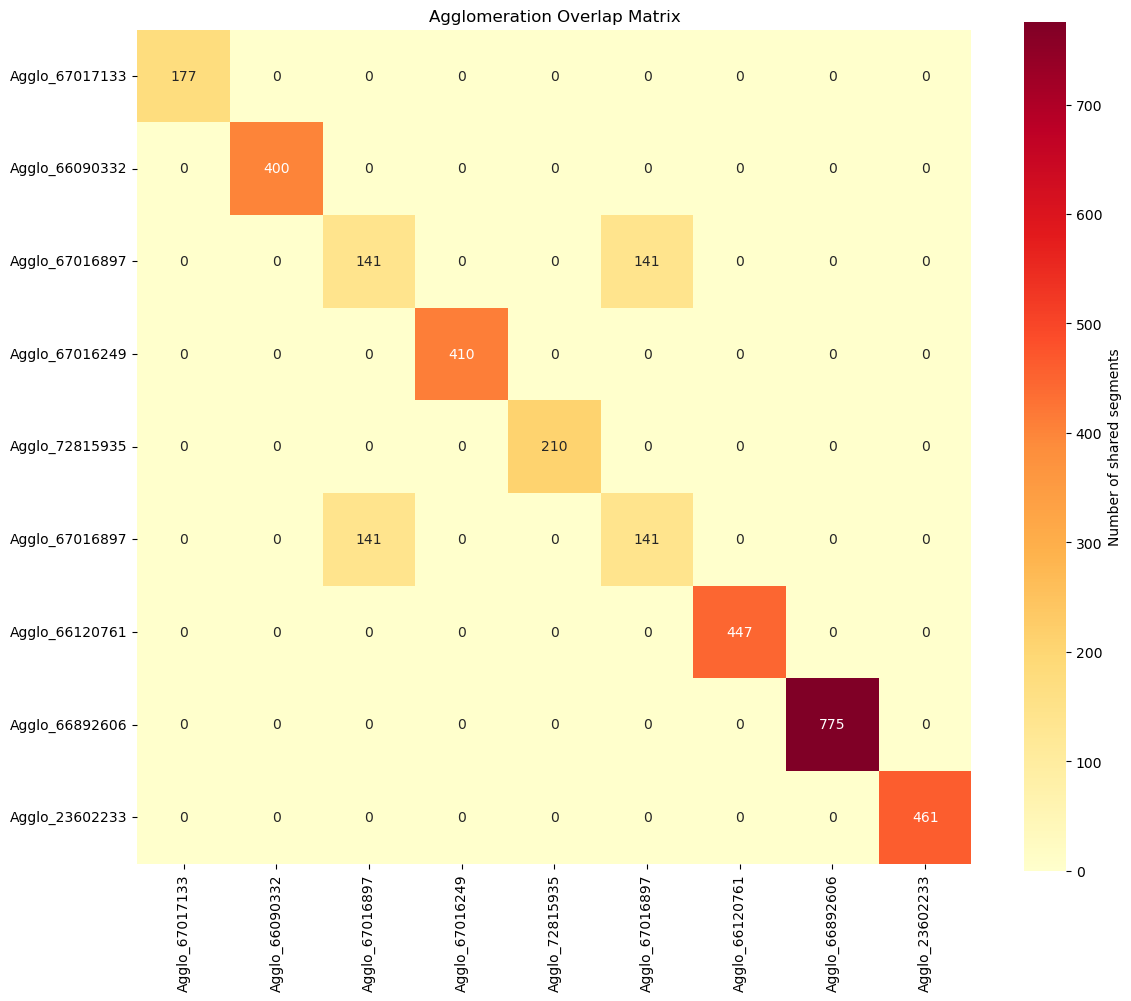


Overlap Matrix:
                Agglo_67017133  Agglo_66090332  Agglo_67016897  \
Agglo_67017133             177               0               0   
Agglo_66090332               0             400               0   
Agglo_67016897               0               0             141   
Agglo_67016249               0               0               0   
Agglo_72815935               0               0               0   
Agglo_67016897               0               0             141   
Agglo_66120761               0               0               0   
Agglo_66892606               0               0               0   
Agglo_23602233               0               0               0   

                Agglo_67016249  Agglo_72815935  Agglo_67016897  \
Agglo_67017133               0               0               0   
Agglo_66090332               0               0               0   
Agglo_67016897               0               0             141   
Agglo_67016249             410               0            

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique agglomeration IDs from your data
agglo_ids = [67017133, 66090332, 67016897, 67016249, 72815935, 67016897, 66120761, 66892606, 23602233]

# Create empty matrix
n = len(agglo_ids)
overlap_matrix = np.zeros((n, n), dtype=int)

# Fill the matrix
for i, agglo1 in enumerate(agglo_ids):
    for j, agglo2 in enumerate(agglo_ids):
        # Get segments for each agglomeration
        segments1 = set(groups_dict[tuple(centroids_xyz[i])][agglo1])
        segments2 = set(groups_dict[tuple(centroids_xyz[j])][agglo2])
        # Calculate overlap
        overlap = len(segments1.intersection(segments2))
        overlap_matrix[i,j] = overlap

# Create DataFrame
overlap_df = pd.DataFrame(
    overlap_matrix,
    index=[f'Agglo_{id}' for id in agglo_ids],
    columns=[f'Agglo_{id}' for id in agglo_ids]
)

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_df,
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='YlOrRd',  # Yellow to Red colormap
            square=True,    # Make cells square
            cbar_kws={'label': 'Number of shared segments'})

plt.title('Agglomeration Overlap Matrix')
plt.tight_layout()
plt.show()

# Also print the raw numbers
print("\nOverlap Matrix:")
print(overlap_df)

In [54]:
import numpy as np
import pandas as pd

# Create dummy segments data with overlapping spatial regions but unique segment IDs
segments_data = {
    'id': range(1, 31),  # 30 unique segments
    'x': [
        # Agglomeration 1 (segments 1-10) - Central region
        10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900,
        # Agglomeration 2 (segments 11-20) - Overlaps with Agglomeration 1
        10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100,
        # Agglomeration 3 (segments 21-30) - Overlaps with Agglomeration 2
        10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300
    ],
    'y': [
        # Agglomeration 1
        10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900,
        # Agglomeration 2 (shifted)
        10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100,
        # Agglomeration 3 (shifted)
        10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300
    ],
    'z': [
        # All z coordinates
        1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900,
        1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900,
        1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900
    ],
    'x_1': [40] * 30,  # Size in x
    'y_1': [40] * 30,  # Size in y
    'z_1': [40] * 30   # Size in z
}

df = pd.DataFrame(segments_data)

# Create groups dictionary with spatially overlapping but unique segments
groups_dict = {
    (10500, 10500, 1500): {  # Central point
        'agglo_1': list(range(1, 11)),      # Segments 1-10
    },
    (10700, 10700, 1500): {  # Shifted point
        'agglo_2': list(range(11, 21)),     # Segments 11-20
    },
    (10900, 10900, 1500): {  # Further shifted point
        'agglo_3': list(range(21, 31)),     # Segments 21-30
    }
}

# Add agglomeration IDs to DataFrame
df['agglo_id'] = None
for point, agglos in groups_dict.items():
    for agglo_id, segments in agglos.items():
        df.loc[df['id'].isin(segments), 'agglo_id'] = agglo_id

print("\nDataFrame head:")
print(df.head())
print("\nSpatial overlap but unique segments:")
for point, agglos in groups_dict.items():
    print(f"\nPoint {point}:")
    for agglo_id, segments in agglos.items():
        print(f"{agglo_id}: {segments}")


DataFrame head:
   id      x      y     z  x_1  y_1  z_1 agglo_id
0   1  10000  10000  1000   40   40   40  agglo_1
1   2  10100  10100  1100   40   40   40  agglo_1
2   3  10200  10200  1200   40   40   40  agglo_1
3   4  10300  10300  1300   40   40   40  agglo_1
4   5  10400  10400  1400   40   40   40  agglo_1

Spatial overlap but unique segments:

Point (10500, 10500, 1500):
agglo_1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Point (10700, 10700, 1500):
agglo_2: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Point (10900, 10900, 1500):
agglo_3: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


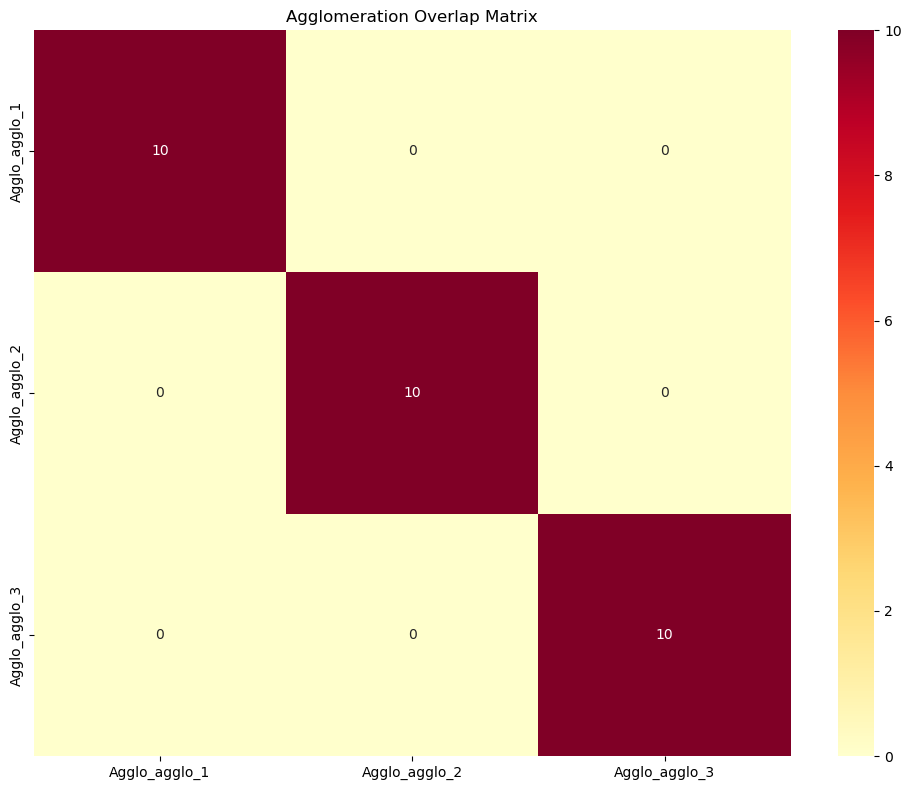

In [55]:
import napari
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from napari_pymeshlab import convex_hull, taubin_smooth

def create_overlap_matrix(groups_dict):
    """Create overlap matrix between agglomerations"""
    # Get unique agglomeration IDs
    agglo_ids = []
    for point, groups in groups_dict.items():
        for agglo_id in groups.keys():
            if agglo_id not in agglo_ids:
                agglo_ids.append(agglo_id)

    # Create empty matrix
    n = len(agglo_ids)
    overlap_matrix = np.zeros((n, n), dtype=int)

    # Fill matrix
    for i, agglo1 in enumerate(agglo_ids):
        for j, agglo2 in enumerate(agglo_ids):
            # Get segments for each agglomeration
            segments1 = set()
            segments2 = set()
            for point, groups in groups_dict.items():
                if agglo1 in groups:
                    segments1.update(groups[agglo1])
                if agglo2 in groups:
                    segments2.update(groups[agglo2])

            # Calculate overlap
            overlap = len(segments1.intersection(segments2))
            overlap_matrix[i,j] = overlap

    return overlap_matrix, agglo_ids

def visualize_agglomerations_and_matrix(df, groups_dict):
    """Visualize agglomerations in napari and overlap matrix in matplotlib"""
    # Create napari viewer
    viewer = napari.Viewer()

    # Create convex hulls for each agglomeration
    colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'cyan']
    color_idx = 0

    for point, groups in groups_dict.items():
        for agglo_id, segments in groups.items():
            # Get all vertices for segments in this agglomeration
            all_vertices = []
            for segment_id in segments:
                segment_data = df[df['id'] == segment_id]
                if len(segment_data) == 0:
                    continue

                # Get coordinates and size
                start = np.array([
                    segment_data['x'].iloc[0],
                    segment_data['y'].iloc[0],
                    segment_data['z'].iloc[0]
                ])
                size = np.array([
                    segment_data['x_1'].iloc[0],
                    segment_data['y_1'].iloc[0],
                    segment_data['z_1'].iloc[0]
                ])

                # Create box vertices
                vertices = np.array([
                    start,
                    start + [size[0], 0, 0],
                    start + [0, size[1], 0],
                    start + [0, 0, size[2]],
                    start + [size[0], size[1], 0],
                    start + [size[0], 0, size[2]],
                    start + [0, size[1], size[2]],
                    start + size
                ])
                all_vertices.extend(vertices)

            # Create convex hull
            vertices = np.array(all_vertices)
            faces = np.array([[i, i+1, i+2] for i in range(0, len(vertices)-2)])
            hull_data = convex_hull((vertices, faces))

            # Add to viewer
            viewer.add_surface(
                hull_data,
                name=f'Agglo_{agglo_id}',
                colormap=colors[color_idx % len(colors)],
                opacity=0.5
            )
            color_idx += 1

    # Create overlap matrix
    overlap_matrix, agglo_ids = create_overlap_matrix(groups_dict)

    # Plot matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlap_matrix,
                xticklabels=[f'Agglo_{id}' for id in agglo_ids],
                yticklabels=[f'Agglo_{id}' for id in agglo_ids],
                annot=True,
                fmt='d',
                cmap='YlOrRd')
    plt.title('Agglomeration Overlap Matrix')
    plt.tight_layout()
    plt.show()

    return viewer

# Use the function
viewer = visualize_agglomerations_and_matrix(df, groups_dict)
napari.run()

In [56]:
df

,id,x,y,z,x_1,y_1,z_1,agglo_id
0,1,10000,10000,1000,40,40,40,agglo_1
1,2,10100,10100,1100,40,40,40,agglo_1
2,3,10200,10200,1200,40,40,40,agglo_1
3,4,10300,10300,1300,40,40,40,agglo_1
4,5,10400,10400,1400,40,40,40,agglo_1
5,6,10500,10500,1500,40,40,40,agglo_1
6,7,10600,10600,1600,40,40,40,agglo_1
7,8,10700,10700,1700,40,40,40,agglo_1
8,9,10800,10800,1800,40,40,40,agglo_1
9,10,10900,10900,1900,40,40,40,agglo_1
